# WORKFLOW 1

### Execute Functions

##### Calculate median execution time for benchmark

In [ ]:
# Define the variables for VUS and DURATION
test_bm_vus = 10
test_bm_duration = "60s"

# Construct the command
command_test_bm = f"cd ../loadtesting/test-benchmark && k6 run --env VUS={test_bm_vus} --env DURATION={test_bm_duration} script.js"

# Run the command
get_ipython().system(f"{command_test_bm}")


         /\      Grafana   /‾‾/  
    /\  /  \     |\  __   /  /   
   /  \/    \    | |/ /  /   ‾‾\ 
  /          \   |   (  |  (‾)  |
 / __________ \  |_|\_\  \_____/ 

     execution: local
        script: script.js
        output: -

     scenarios: (100.00%) 1 scenario, 10 max VUs, 1m0s max duration (incl. graceful stop):
              * default: 10 looping VUs for 30s (gracefulStop: 30s)


running (0m00.1s), 10/10 VUs, 0 complete and 0 interrupted iterations
default   [--------------------------------------] 10 VUs  00.1s/30s

running (0m00.2s), 10/10 VUs, 0 complete and 0 interrupted iterations
default   [--------------------------------------] 10 VUs  00.2s/30s

running (0m00.3s), 10/10 VUs, 0 complete and 0 interrupted iterations
default   [--------------------------------------] 10 VUs  00.3s/30s

running (0m00.4s), 10/10 VUs, 0 complete and 0 interrupted iterations
default   [--------------------------------------] 10 VUs  00.4s/30s

running (0m00.5s), 10/10 VUs, 0 complete

In [10]:
import json

file_path = "../loadtesting/test-benchmark/summary.json"

# Load the JSON file
with open(file_path, 'r') as file:
    data = json.load(file)

# Access the values of 'min' and 'med'
min_value_sec = data['total_duration']['values']['min']
med_value_sec = data['total_duration']['values']['med']
max_value_sec = data['total_duration']['values']['max']

# Convert seconds to microseconds
min_value_us = int(min_value_sec * 1_000_000)
med_value_us = int(med_value_sec * 1_000_000)
max_value_us = int(max_value_sec * 1_000_000)

# Print the results
print(f"Min: {min_value_us} µs")
print(f"Med: {med_value_us} µs")
print(f"Max: {max_value_us} µs")

percent_improvement = 0.05
# percent_improvement = 0.025

bm_max_duration = str(med_value_us - int(percent_improvement * med_value_us))
print("\nBM threshold: " + bm_max_duration + " µs")

Min: 3547 µs
Med: 3888 µs
Max: 85722 µs

BM threshold: 3694 µs


##### Load test GCP-Functions: OPTIMIZED and BASELINE

In [11]:
# Define the variables for VUS and DURATION
vus = 3
duration = "600s"

# Define max bm duration and add param to url
maxBenchmarkDuration = bm_max_duration + "us" if bm_max_duration else "3850us"
optimized_url = f"https://europe-west3-bsc-thesis-implementation.cloudfunctions.net/optimizedFunction?maxBenchmarkDuration={maxBenchmarkDuration}"

# Construct the individual commands for each `k6` run
command_optimized = f"cd ../loadtesting/test-function-optimized && k6 run --env URL='{optimized_url}' --env VUS={vus} --env DURATION={duration} script.js"
command_baseline = f"cd ../loadtesting/test-function-baseline && k6 run --env VUS={vus} --env DURATION={duration} script.js"

# Run both commands in the background
get_ipython().system(f"({command_optimized}) & ({command_baseline})")


         /\      Grafana   /‾‾/  
    /\  /  \     |\  __   /  /   
   /  \/    \    | |/ /  /   ‾‾\ 
  /          \   |   (  |  (‾)  |
 / __________ \  |_|\_\  \_____/ 


         /\      Grafana   /‾‾/  
    /\  /  \     |\  __   /  /   
   /  \/    \    | |/ /  /   ‾‾\ 
  /          \   |   (  |  (‾)  |
 / __________ \  |_|\_\  \_____/ 

     execution: local
        script: script.js
        output: -

     scenarios: (100.00%) 1 scenario, 3 max VUs, 10m30s max duration (incl. graceful stop):
              * default: 3 looping VUs for 10m0s (gracefulStop: 30s)

     execution: local
        script: script.js
        output: -

     scenarios: (100.00%) 1 scenario, 3 max VUs, 10m30s max duration (incl. graceful stop):
              * default: 3 looping VUs for 10m0s (gracefulStop: 30s)

WARN[0000] Error from API server                         error="listen tcp 127.0.0.1:6565: bind: address already in use"

running (00m00.1s), 3/3 VUs, 0 complete and 0 interrupted iterations
default

---

### Fetch data

##### Import PYTHON modules

In [12]:
import sys 
import os
sys.path.append(os.path.abspath("logs_fetch"))

from logs_fetch.logs_fetch import PROJECT_ID
from logs_fetch.logs_fetch import CloudFunction
from logs_fetch.logs_fetch import fetch_logs_and_save

from logs_metrics.calc_median_function_execution import return_median_function_execution_BASELINE
from logs_metrics.calc_median_function_execution import return_median_function_execution_OPTIMIZED

from logs_metrics.calc_median_download import return_median_download_BASELINE
from logs_metrics.calc_median_download import return_median_download_OPTIMIZED

from logs_metrics.calc_median_lr_duration import return_median_lr_duration_BASELINE
from logs_metrics.calc_median_lr_duration import return_median_lr_duration_OPTIMIZED

##### Fetch logs

In [13]:
fetch_logs_and_save(CloudFunction.OPTIMIZED, PROJECT_ID, 15)

Analyzing logs for Cloud Function: optimizedFunction
Logs saved to ./logs_archive/2024-12-02-optimizedFunction-logs.csv



In [14]:
import time
time.sleep(60)

fetch_logs_and_save(CloudFunction.BASELINE, PROJECT_ID, 15)

Analyzing logs for Cloud Function: baselineFunction
Logs saved to ./logs_archive/2024-12-02-baselineFunction-logs.csv



---

### Perform Analysis

##### Calculate Metrics

In [30]:
import pandas as pd

median_function_execution = return_median_function_execution_BASELINE(), return_median_function_execution_OPTIMIZED()
median_download_duration = return_median_download_BASELINE(), return_median_download_OPTIMIZED()
median_lr_duration = return_median_lr_duration_BASELINE(), return_median_lr_duration_OPTIMIZED()

data = {
    "Metric": ["Function Execution Time", "Download Duration", "Linear Regression Execution Time"],
    "Baseline": [median_function_execution[0], median_download_duration[0], median_lr_duration[0]],
    "Optimized": [median_function_execution[1], median_download_duration[1], median_lr_duration[1]],
}

# Create DataFrame
df = pd.DataFrame(data)

# Calculate % Improvement and add as a new column
df["% Improvement"] = ((df["Baseline"] - df["Optimized"]) / df["Baseline"]) * 100

# Display DataFrame
# print(df)

# Conditional styling
styled_df = df.style.format({"Baseline": "{:.1f}", "Optimized": "{:.1f}", "% Improvement": "{:.1f}"}) \
                    .map(lambda x: 'color: red;' if x < 0 else 'color: green;', subset=["% Improvement"]) \
                   .set_table_styles([{
                       'selector': 'thead th', 
                       'props': [
                           ('background-color', '#f2f2f2'), 
                           ('color', 'black'), 
                           ('font-size', '16px'), 
                           ('text-align', 'center')
                           ],
                       }
                       ]) \
                   .set_properties(**{
                       'border': '1px solid black',
                       'text-align': 'center',
                       'font-size': '14px',
                       'padding': '10px',
                   }) \
                   .hide(axis="index")

# Display the styled DataFrame
styled_df

Metric,Baseline,Optimized,% Improvement
Function Execution Time,1567.0,1664.0,-6.2
Download Duration,131.0,116.5,11.1
Linear Regression Execution Time,1436.0,1452.5,-1.1


---

### Create Graphics with Seaborn

#### Execution Time

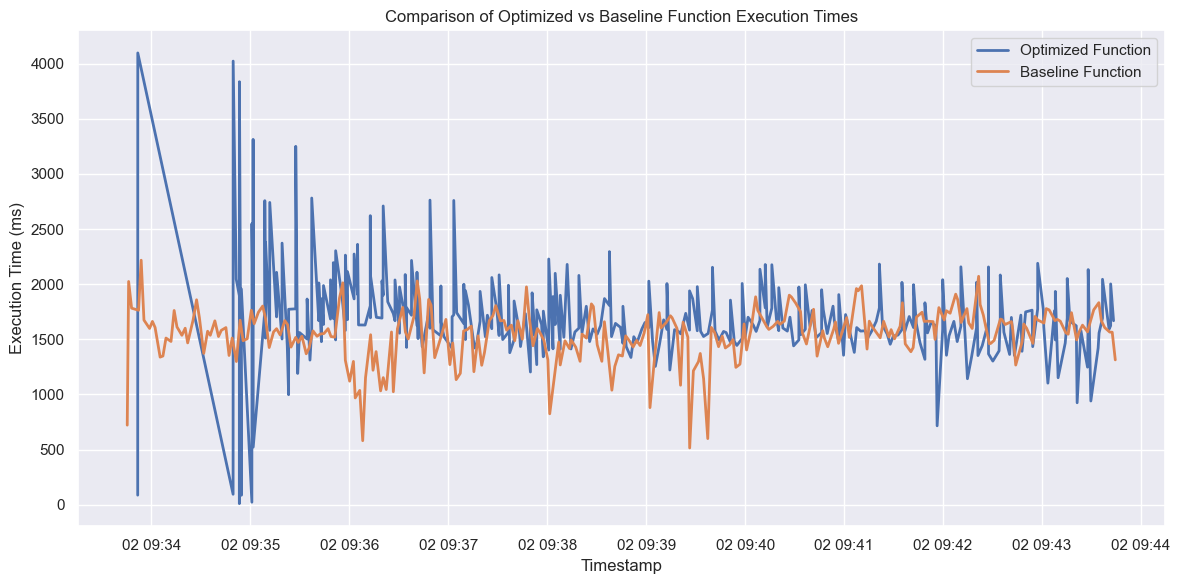

In [32]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime

# Load data
today_date = datetime.now().strftime("%Y-%m-%d")

df_optimized = pd.read_csv(f"./logs_archive/{today_date}-optimizedFunction-logs.csv")
df_baseline = pd.read_csv(f"./logs_archive/{today_date}-baselineFunction-logs.csv")

# Convert 'timestamp' column to datetime
df_optimized['timestamp'] = pd.to_datetime(df_optimized['timestamp'])
df_baseline['timestamp'] = pd.to_datetime(df_baseline['timestamp'])

sns.set_theme(style="darkgrid")  # Options: darkgrid, whitegrid, dark, white, ticks
palette = sns.color_palette("deep")  # Options: "Set1", "Set2", "Set3", "coolwarm", "viridis", etc.

# Create the plot
plt.figure(figsize=(12, 6))

# Plot optimized function execution time
sns.lineplot(data=df_optimized, x='timestamp', y='execution_time', color=palette[0], label='Optimized Function', lw=2)

# Plot baseline function execution time
sns.lineplot(data=df_baseline, x='timestamp', y='execution_time', color=palette[1], label='Baseline Function', lw=2)

# Add labels and title
plt.xlabel('Timestamp')
plt.ylabel('Execution Time (ms)')
plt.title('Comparison of Optimized vs Baseline Function Execution Times')

# Add a legend
plt.legend()

# Show plot
plt.tight_layout()
plt.show() 

##### Rolling average

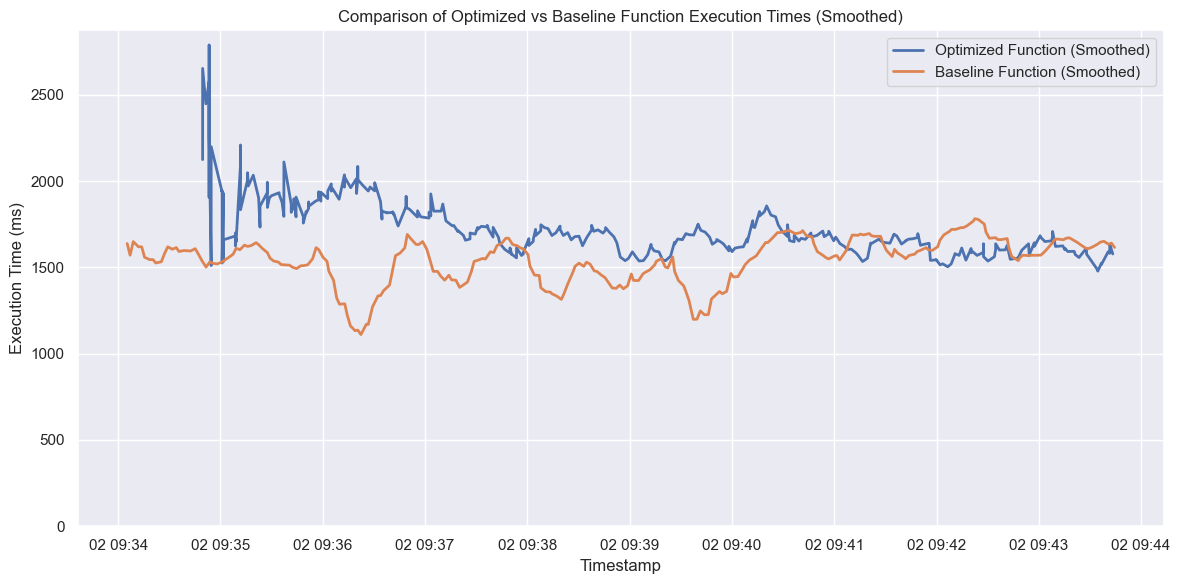

In [33]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime

# Load data
today_date = datetime.now().strftime("%Y-%m-%d")

df_optimized = pd.read_csv(f"./logs_archive/{today_date}-optimizedFunction-logs.csv")
df_baseline = pd.read_csv(f"./logs_archive/{today_date}-baselineFunction-logs.csv")

# Convert 'timestamp' column to datetime
df_optimized['timestamp'] = pd.to_datetime(df_optimized['timestamp'])
df_baseline['timestamp'] = pd.to_datetime(df_baseline['timestamp'])

# Apply rolling average
window_size = 10  # Adjust window size as needed
df_optimized['smoothed_execution_time'] = df_optimized['execution_time'].rolling(window=window_size).mean()
df_baseline['smoothed_execution_time'] = df_baseline['execution_time'].rolling(window=window_size).mean()

sns.set_theme(style="darkgrid")
palette = sns.color_palette("deep")

# Create the plot
plt.figure(figsize=(12, 6))

# Plot optimized function execution time
sns.lineplot(data=df_optimized, x='timestamp', y='smoothed_execution_time', color=palette[0], label='Optimized Function (Smoothed)', lw=2)

# Plot baseline function execution time
sns.lineplot(data=df_baseline, x='timestamp', y='smoothed_execution_time', color=palette[1], label='Baseline Function (Smoothed)', lw=2)

# Add labels and title
plt.xlabel('Timestamp')
plt.ylabel('Execution Time (ms)')
plt.title('Comparison of Optimized vs Baseline Function Execution Times (Smoothed)')

plt.ylim(bottom=0)

# Add a legend
plt.legend()

# Show plot
plt.tight_layout()
plt.show()

##### Y-axis from 0

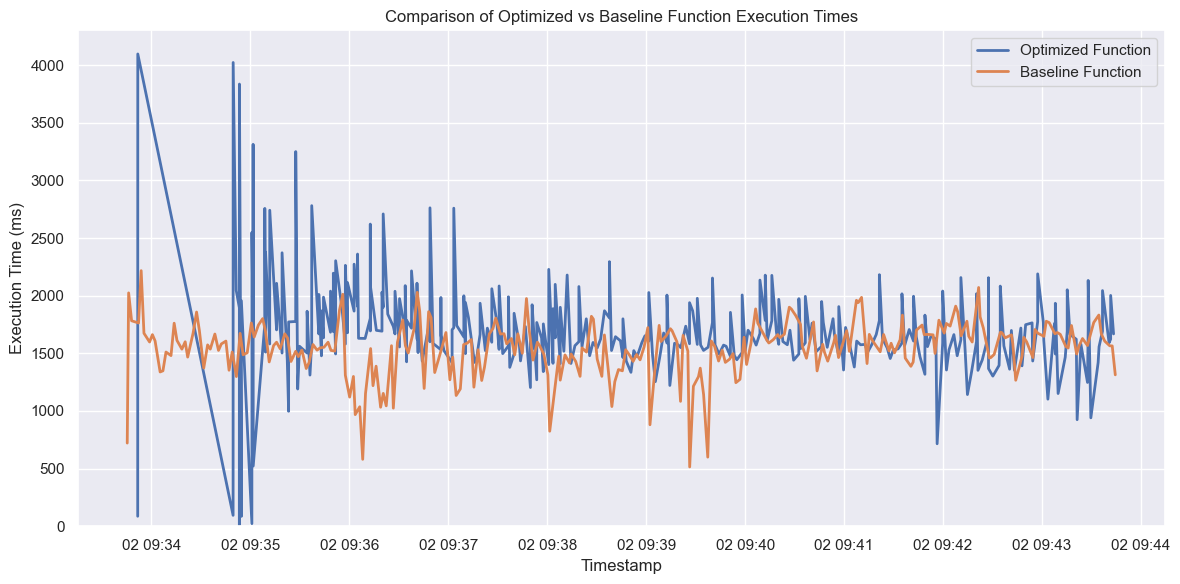

In [34]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime

# Load data
today_date = datetime.now().strftime("%Y-%m-%d")

df_optimized = pd.read_csv(f"./logs_archive/{today_date}-optimizedFunction-logs.csv")
df_baseline = pd.read_csv(f"./logs_archive/{today_date}-baselineFunction-logs.csv")

# Convert 'timestamp' column to datetime
df_optimized['timestamp'] = pd.to_datetime(df_optimized['timestamp'])
df_baseline['timestamp'] = pd.to_datetime(df_baseline['timestamp'])

sns.set_theme(style="darkgrid")  # Options: darkgrid, whitegrid, dark, white, ticks
palette = sns.color_palette("deep")  # Options: "Set1", "Set2", "Set3", "coolwarm", "viridis", etc.

# Create the plot
plt.figure(figsize=(12, 6))

# Plot optimized function execution time
sns.lineplot(data=df_optimized, x='timestamp', y='execution_time', color=palette[0], label='Optimized Function', lw=2)

# Plot baseline function execution time
sns.lineplot(data=df_baseline, x='timestamp', y='execution_time', color=palette[1], label='Baseline Function', lw=2)

# Add labels and title
plt.xlabel('Timestamp')
plt.ylabel('Execution Time (ms)')
plt.title('Comparison of Optimized vs Baseline Function Execution Times')

# Set y-axis to start from 0
plt.ylim(bottom=0)

# Add a legend
plt.legend()

# Show plot
plt.tight_layout()
plt.show()

---

#### Linear Regression Duration

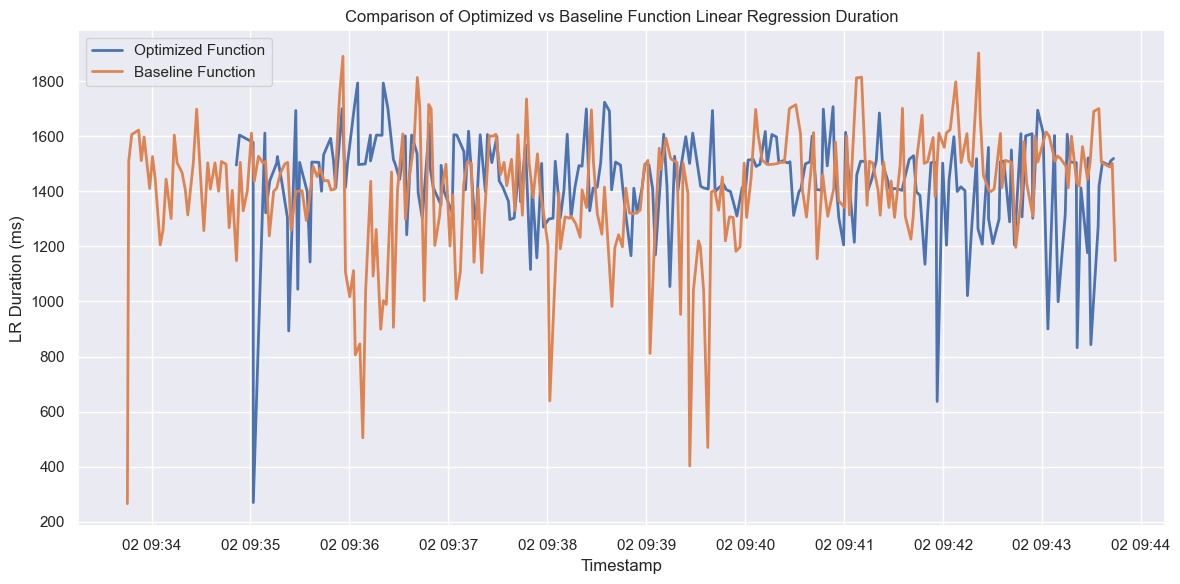

In [35]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime

# Load data
today_date = datetime.now().strftime("%Y-%m-%d")

df_optimized = pd.read_csv(f"./logs_archive/{today_date}-optimizedFunction-logs.csv")
df_baseline = pd.read_csv(f"./logs_archive/{today_date}-baselineFunction-logs.csv")

# Convert 'timestamp' column to datetime
df_optimized['timestamp'] = pd.to_datetime(df_optimized['timestamp'])
df_baseline['timestamp'] = pd.to_datetime(df_baseline['timestamp'])

# Filter out zeros from crashed instances
df_optimized = df_optimized[df_optimized['lr_duration'] != 0]

sns.set_theme(style="darkgrid")  # Options: darkgrid, whitegrid, dark, white, ticks
palette = sns.color_palette("deep")  # Options: "Set1", "Set2", "Set3", "coolwarm", "viridis", etc.

# Create the plot
plt.figure(figsize=(12, 6))

# Plot optimized function execution time
sns.lineplot(data=df_optimized, x='timestamp', y='lr_duration', color=palette[0], label='Optimized Function', lw=2)

# Plot baseline function execution time
sns.lineplot(data=df_baseline, x='timestamp', y='lr_duration', color=palette[1], label='Baseline Function', lw=2)

# Add labels and title
plt.xlabel('Timestamp')
plt.ylabel('LR Duration (ms)')
plt.title('Comparison of Optimized vs Baseline Function Linear Regression Duration')

# Add a legend
plt.legend()

# Show plot
plt.tight_layout()
plt.show() 

##### Rolling average: LR-duration

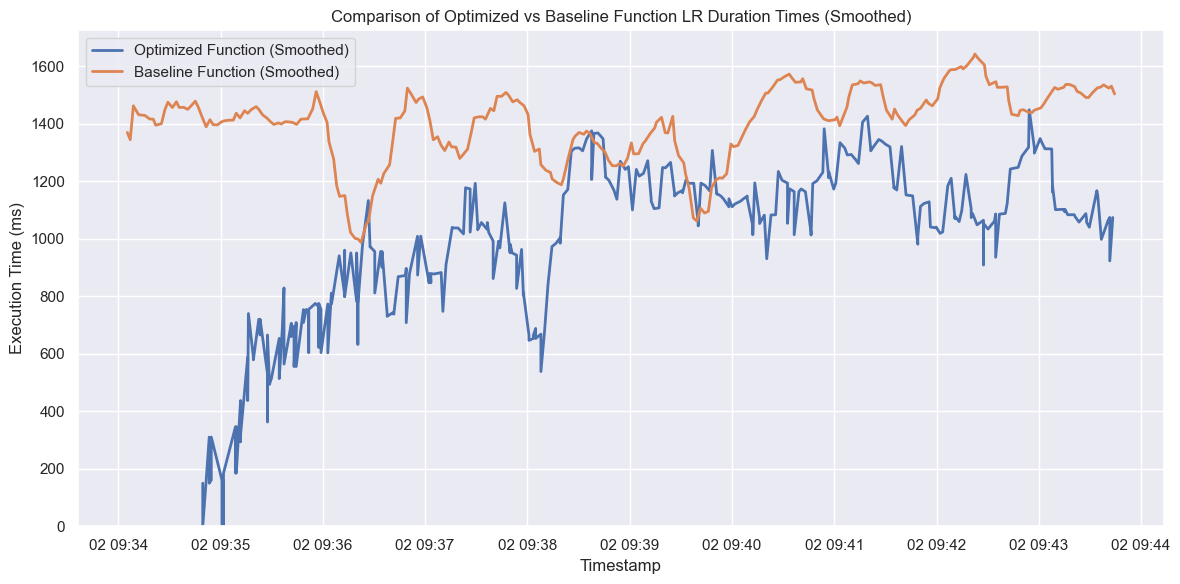

In [41]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime

# Load data
today_date = datetime.now().strftime("%Y-%m-%d")

df_optimized = pd.read_csv(f"./logs_archive/{today_date}-optimizedFunction-logs.csv")
df_baseline = pd.read_csv(f"./logs_archive/{today_date}-baselineFunction-logs.csv")

# Convert 'timestamp' column to datetime
df_optimized['timestamp'] = pd.to_datetime(df_optimized['timestamp'])
df_baseline['timestamp'] = pd.to_datetime(df_baseline['timestamp'])

# Apply rolling average
window_size = 10  # Adjust window size as needed
df_optimized['smoothed_execution_time'] = df_optimized['lr_duration'].rolling(window=window_size).mean()
df_baseline['smoothed_execution_time'] = df_baseline['lr_duration'].rolling(window=window_size).mean()

sns.set_theme(style="darkgrid")
palette = sns.color_palette("deep")

# Create the plot
plt.figure(figsize=(12, 6))

# Plot optimized function execution time
sns.lineplot(data=df_optimized, x='timestamp', y='smoothed_execution_time', color=palette[0], label='Optimized Function (Smoothed)', lw=2)

# Plot baseline function execution time
sns.lineplot(data=df_baseline, x='timestamp', y='smoothed_execution_time', color=palette[1], label='Baseline Function (Smoothed)', lw=2)

# Add labels and title
plt.xlabel('Timestamp')
plt.ylabel('Execution Time (ms)')
plt.title('Comparison of Optimized vs Baseline Function LR Duration Times (Smoothed)')

plt.ylim(bottom=0)

# Add a legend
plt.legend()

# Show plot
plt.tight_layout()
plt.show()

---